<a href="https://colab.research.google.com/github/bbazzan/TP_ISING/blob/master/Tp_Ising_Bazzan%2C_Cerizola%2C_Mollerach%2C_Queirolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<h1>Práctica computacional: modelo de Ising en 2D</h1>**

El objetivo de la práctica es calcular varios observables (magnetización, energía, susceptibilidad, calor específico) de una red de Ising bidimensional en función de la temperatura, y ver cómo a $T\simeq 2.27$ (usamos unidades en las que $J=k=1$) tiene lugar una transición de fase. También calcularemos la función de correlación y estudiaremos la dependencia de la longitud de correlación con la temperatura. Dado que el número de términos en la función de partición es gigantesco ($2^{100}$ para una red $10\times 10$, algo así como la edad del universo en décimas de picosegundo), no podemos aspirar a calcular la función de partición exactamente. En su lugar, lo que hacemos es generar estados aleatorios de la red distribuidos según el ensamble canónico, y tomar promedios sobre varios de esos estados. Para lograr eso, partimos de un estado inicial cualquiera y le aplicamos el **algoritmo de Metropolis**, que consta de los siguientes pasos:

1.   Elegimos un sitio de la red al azar.
2.   Calculamos la diferencia de energía $\Delta E$ que resultaría de darle vuelta a ese spin.
3. Si $\Delta E\le 0$, le damos vuelta al spin; si $\Delta E>0$, le damos vuelta al spin con probabilidad $e^{-\beta\Delta E}$.

Al estado resultante le volvemos a aplicar el algoritmo, y así sucesivamente. Después de ser iterado muchas veces, el algoritmo empieza a generar estados distribuidos según el ensamble canónico. Tomando promedios sobre varios de esos estados, podremos calcular los observables de interés.










# Bibliotecas

Importamos las bibliotecas de Python que vamos a usar: numpy, que permite definir y operar con matrices, genera números aleatorios, incluye todo tipo de funciones matemáticas, etc; matplotlib.pyplot, que permite hacer gráficos; y numba, que es un compilador que hace que las funciones corran mucho más rápido. También importamos la función curve_fit del paquete scipy.optimize, que nos servirá para hacer ajustes.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.optimize import curve_fit

# Funciones

Aquí van a tener que definir dos funciones. La primera, **`h(S)`**, calcula la energía por partícula de la red en el estado **`S`** (nótese que **`S`** es una matriz de $1$'s y $-1$'s). Asumimos que no hay campo magnético y usamos condiciones de contorno periódicas, de manera que el primer spin de una fila/columna es vecino del último. Si la red es $L\times L$, la energía total es entonces 

$$H(S)=-\sum_{i,j=1}^L S_{ij}(S_{i-1 j}+S_{ij-1}),$$

y la energía por partícula es esto dividido por $L^2$. La segunda función, **`metropolis(S,prob)`**, aplica el algoritmo de Metropolis al estado **`S`** y devuelve tres cosas: un nuevo estado **`S`**, el incremento de magnetización **`dm`** y el incremento de energía por partícula **`de`**. Deben notar que los únicos valores positivos que puede tomar el incremento de energía $\Delta E$ resultante de dar vuelta a un spin son $\Delta E=4$ y $\Delta E=8$; el argumento **`prob`** es un vector de dos componentes, **`prob[0]`** y **`prob[1]`**, que son las probabilidades con las que daremos vuelta al spin si el incremento de energía es $4$ y $8$ respectivamente. Algunos consejos:


*   Para implementar las condiciones de contorno periódicas, conviene recordar que las listas de Python empiezan con el elemento $0$, el elemento $-1$ es el último, el $-2$ el penúltimo, etc. También les va a ser útil la función **`%`**, que calcula el residuo de la división entre dos enteros (es decir, **`m%n`** es el residuo de la división entre **`m`** y **`n`**).
*   ¡Sean económicos! Para calcular $\Delta E$ no deben calcular la energía total de los dos estados (el estado original y el estado con el spin seleccionado dado vuelta) y restar, sino darse cuenta de que esta cantidad sólo involucra al estado del spin seleccionado y el de sus cuatro primeros vecinos.
*   Para dar vuelta a un spin con probabilidad $p$, lo que hacemos es generar un número aleatorio entre $0$ y $1$ y darle vuelta al spin si ese número es menor que $p$.

Una vez hayan definido estas funciones, primero de todo asegúrense de que andan bien probándolas con una matriz $3\times 3$, por ejemplo tomando **`S=np.ones((3,3))`**. Ahí pueden calcular a mano la energía por partícula y chequear que **`h(S)`** da el resultado correcto. También pueden asegurarse de que la funcion **`metropolis(S,prob)`** da vuelta a algún spin más fácilmente a temperaturas altas que a temperaturas bajas, y que los incrementos de magnetización y energía por partícula que calcula son los correctos. Una vez hayan hecho eso, redefinan la función **`metropolis(S,prob)`** de manera que aplique el algoritmo de Metropolis no una sola vez sino tantas como sitios tiene la red. Es decir, su función definitiva debería aplicar el algoritmo al estado original, y después volvérselo a aplicar al estado resultante, y así tantas veces como sitios tiene la red. De vuelta, comprueben que esta función anda bien con una matriz sencilla.

In [ ]:
@njit 
def h(S): 
    '''Calcula la energía de la red en el estado S'''
    
    energia = 0
    L = len(S)
    for i in range(L):
        for j in range(L):
            energia += -S[i,j] * (S[i-1,j] + S[i,j-1])
    return energia / L**2

@njit
def metropolis(S, prob): 
    '''Aplica el algoritmo de Metropolis al estado S, y devuelve la configuración final S, la 
diferencia de magnetización (de) y la diferencia de energía por partícula (dm)'''
    
    # Inicializamos variables
    L = len(S)
    de = 0
    dm = 0
    # Aleatoriamente tomamos los valores de los indices i,j entre 0 y L - 1
    for k in range(L*L):
        i = np.random.randint(L)
        j = np.random.randint(L)
        spin = S[i,j]

        # Nos fijamos cuánto es la diferencia de energía y la diferencia de 
        #magnetización si diesemos vuelta el spin
        dif_energia = 2 * S[i,j] * (S[(i+1) % L, j] + S[i-1, j] + 
                                    S[i, (j+1) % L] + S[i, j-1])
        
        # Si cambiando el spin obtenemos menor energía nos quedamos con ese
        # sino tenemos una probabilidad prob[] de quedarnos con el estado cambiado
        if dif_energia<=0 or np.random.rand()<prob[int((dif_energia-4)/4)]:
            de += dif_energia / L**2
            dm += -2 * S[i,j] / L**2
            S[i, j] *= -1

    return S, dm, de

**Probamos h(S)**

In [ ]:
# Tomamos una red de 1's y calculo su energía con h(S)
s_prueba_h = np.ones((3, 3), dtype=int)
energia = h(s_prueba_h)
print("Red:")
print(s_prueba_h)
print("\nValor esperado de la energía: -2")
print("Valor obtenido: ", energia)

# Nos fijamos si el valor es el esperado
if energia == -2:
    print("\nLa función h(S) funciona como debería.")

Red:
[[1 1 1]
 [1 1 1]
 [1 1 1]]

Valor esperado de la energía: -2
Valor obtenido:  -2.0

La función h(S) funciona como debería.


**Probamos metropolis(S, prob)**

In [ ]:
from math import isclose

# Modiicamos metropolis(S, prob) para que nos devuelva el numero de spines cambiados
@njit
def num_flipped(S, prob):
    '''Devuelve el numero de spines cambiados al aplicar el algoritmo de metropolis'''

    L = len(S)
    flipped = 0
    for k in range(L*L):
        i = np.random.randint(L)
        j = np.random.randint(L)
        spin = S[i,j]
        dif_energia = 2 * S[i,j] * (S[(i+1) % L, j] + S[i-1, j] + 
                                    S[i, (j+1) % L] + S[i, j-1])
        
        if dif_energia<=0 or np.random.rand()<prob[int((dif_energia-4)/4)]:
            S[i, j] *= -1
            flipped += 1
     
    return flipped


print("Tomamos una configuración al azar, aplicamos el algoritmo para "
      "distintas temperaturas y nos fijamos el numero de spines dados vuelta.\n")
# Tomamos una red de spines al azar
s_prueba_met = 2*np.random.randint(2, size=(30, 30)) - 1

# Calculamos prob[] para dos temperaturas distintas
T1 = 0.5
prob1=np.array([np.exp(-4/T1),np.exp(-8/T1)])
T2 = 10
prob2=np.array([np.exp(-4/T2),np.exp(-8/T2)])

# Nos fijamos cuantos spines se cambian para cada caso
spines_cambiados_1 = num_flipped(s_prueba_met, prob1)
spines_cambiados_2 = num_flipped(s_prueba_met, prob2)
print("Para T =", T1, "K se cambiaron", spines_cambiados_1, "spines")
print("Para T =", T2, "K se cambiaron", spines_cambiados_2, "spines \n")

# Checkeamos que a mayor temperatura cambian más fácilmente
if ((T1 < T2 and spines_cambiados_1 < spines_cambiados_2) or 
    (T1 > T2 and spines_cambiados_1 > spines_cambiados_2)):
    primera_prueba = True
else:
    primera_prueba = False
    
print("Ahora veamos que devuelve los valores correctos de de y dm \n")

# Calculamos la energía por particula con h(S) y la magnetización como el 
# valor medio de la red inicilmente
m_inicial = np.mean(s_prueba_met)
e_inicial = h(s_prueba_met)

# Tomamos los valores de de y dm que nos devuelve la función metropolis(S, prob)
s_prueba_met, dm, de = metropolis(s_prueba_met, prob1)

# Calculamos la energía por particula y la magnetización de la red resultante
m_final = np.mean(s_prueba_met)
e_final = h(s_prueba_met)

print("Valores iniciales:")
print("e = ", round(e_inicial, 2))
print("m = ", round(m_inicial, 2))
print("")
print("Valores finales:")
print("e = ", round(e_final, 2))
print("m = ", round(m_final, 2))
print("")
print("Valores obtenidos con la función metropolis(S, prob):")
print("de = ", round(de, 2))
print("dm = ", round(dm, 2))
print("")

# Nos fijamos si los valores de y dm que devuelve metropolis(S, prob) son los correctos
# Usamos la función 'isclose()' con una tolerancia de 1e-6 en vez de '==' 
# ya que pueden haber diferencias por redondeo
if (isclose(e_final, e_inicial+de, abs_tol=1e-6) and 
    isclose(m_final, m_inicial+dm, abs_tol=1e-6)):
    segunda_prueba = True
else:
    segunda_prueba = False

# Nos fijamos que metropolis(S, prob) haya pasado las dos pruebas
if primera_prueba and segunda_prueba:
    print("La función metropolis(S, prob) funciona como debería.")

Tomamos una configuración al azar, aplicamos el algoritmo para distintas temperaturas y nos fijamos el numero de spines dados vuelta.

Para T = 0.5 K se cambiaron 448 spines
Para T = 10 K se cambiaron 745 spines 

Ahora veamos que devuelve los valores correctos de de y dm 

Valores iniciales:
e =  -0.27
m =  0.05

Valores finales:
e =  -0.84
m =  0.08

Valores obtenidos con la función metropolis(S, prob):
de =  -0.56
dm =  0.02

La función metropolis(S, prob) funciona como debería.


**Explicación h(S):** 

Representamos la energia total con la variable `energia`. Empezamos inicializando éste valor a 0 y tomamos $L$ como `len(S)` ya que trabajaremos con matrices cuadradas. 

Para poder realizar la sumatoria necesitamos recorrer todos los elemtentos de la matriz, para ello hacemos dos búcles `for`, primero uno donde se recorra una variable `i` de $0$ a $L-1$, y dentro de éste otro donde se recorra una variable `j` de la misma manera. De esta manera podemos recorrer todos los elemtentos de la matriz con `S[i,j]`.

Entonces en cada iteración podemos calcular cada término $-S_{ij}(S_{i-1 j}+S_{ij-1})$ y sumarselo a la variable `energia` con `energia += -S[i,j] * (S[i-1,j] + S[i,j-1])`. Notemos que no hay errores de índices, si estamos en la primera fila estamos viendo los elementos `S[0,j]`, y de acuerdo a las condiciones de contorno períodicas `S[-1,j]` debería ser el elemento en la misma columna y última fila, lo cual es cierto ya que en Python el último elemento tiene indice $-1$. Lo mismo pasa con `j`.

Una vez ejecutados los búcles la función devuelve el valor de `energia` pero dividido por $L^2$ ya que éste valor es la energía total y nos piden la energía por partícula.

**Explicación metropolis(S, prob):** 

Empezamos inicializando las variables de diferencia de magnetización (`dm`) y energía por particula (`de`) a $0$ y como antes tomamos $L$ como `len(S)`. Como se nos pide que la función aplique el algoritmo tantas veces como elemtentos de $S$ hacemos un búcle `for` que recorra una variable `k` de $0$ a $L^2$, dentro escribimos el algoritmo en sí. 

Primero tomamos un elemento $S_{i j}$ aleatoriamente, para ello tomamos valores aleatorios entre $0$ y $L-1$ para las variables `i` y `j`, luego calculamos la diferencia de energía si diesemos vuelta ese spin. Para el spin elegido y sus cuatro primeros vecinos tenemos una energía

$$E_{i,j} = -S_{i,j}(S_{i+1,j} + S_{i-1,j} + S_{i,j+1} + S_{i,j-1}),$$

y si disemos vuelta el spin ahora tendríamos

$$E_{i,j} = S_{i,j}(S_{i+1,j} + S_{i-1,j} + S_{i,j+1} + S_{i,j-1}).$$

Entonces la diferencia de energía $\Delta E$ que resultaría de cambiar el spin sería

$$\Delta E_{i,j} = 2 S_{i,j}(S_{i+1,j} + S_{i-1,j} + S_{i,j+1} + S_{i,j-1}).$$

Entonces calculamos este valor y lo guardamos en una variable `dif_energia`. Para referirnos al elemento de la izquierda de $S_{ij}$ y al de arriba volvemos a usar las expresiones de antes, `S[i, j-1]` y `S[i-1, j]` respectivamente. Pero ahora para el elemento de la derecha y el de abajo no podemos usar `S[i, j+1]` y `S[i+1, j]` ya que por ejemplo si estuviesemos viendo algún elemento de la última fila `S[L-1, j]` el vecino de "abajo" sería `S[L,j]`, pero esto está mal ya que `i` va de $0$ a $L-1$. En este caso necesitamos que este vecino sea `S[0,j]`, es decir, que esté en la misma columna pero en la primera fila. 

Para solucionar este problema podemos utilizar el operador módulo `%`. `m % n` es el residuo de la dívision entre `m`y `n`, si `m` es menor que `n` entonces `m % n = m` y si son iguales `m % n = 0`.
Entonces podemos escribir el elemento de la derecha y el de abajo como `S[i, (j+1) % L]` y `S[(i+1) % L, j]`. 

Si estamos considerando un `i` menor que $L-1$ entonces `S[(i+1) % L, j] = S[i+1, j]`, pero si estamos en el caso especial en que `i = L - 1` tenemos `S[(L-1+1) % L, j] = S[L%L, j] = S[0, j]`, y lo mismo para `j`.

Juntando todo, calculamos la diferencia de energía como `dif_energia = 2 * S[i,j] * (S[(i+1) % L, j] + S[i-1, j] + S[i, (j+1) % L] + S[i, j-1])`. 

Ahora nos fijamos si esta diferencia es menor o igual a cero (`if dif_energia <= 0`), de ser así damos vuelta el spin. Sino damos vuelta el spin con probabilidad $e^{-\beta\Delta E}$. Si $\Delta E > 0$ solo puede ser $4$ u $8$, las probabilidades para estos dos casos son las componentes del argumento `prob`. Entonces se da vuelta el spin si al generar un número aleatorio entre $0$ y $1$ éste es menor que `prob[idx]`, donde `idx = 0` para $\Delta E = 4$ y `idx = 1` para $\Delta E = 8$, para ello tomamos `idx = (dif_energia-4)/4)`. Como numba compila las funciones antes de ser ejecutadas y de antemano no sabe que `idx` es un entero, para que no haya errores tomamos `idx = int((dif_energia-4)/4))`. Juntando todo esto el condicional para dar vuelta el spin se puede escribir como 
`if dif_energia<=0 or np.random.rand()<prob[int((dif_energia-4)/4)]:`

Al dar vuelta el spin también debemos sumar la diferencia de energía por particula a la variable `de` y la diferencia de magnetización a `dm`. El primer valor no es más que $\Delta E / L^2$. Veamos el segundo, la magnetización $M$ es el valor medio de la red entonces

$$M = \frac{(S_{0 0} + ... + S_{i j} + ... + S_{L-1 L-1})}{L^2},$$

y si damos vuelta el spin 

$$M' = \frac{(S_{0 0} + ... - S_{i j} + ... + S_{L-1 L-1})}{L^2},$$

entonces 

$$\Delta M = -\frac{2 S_{i j}}{L^2}.$$

Una vez que se ejecúte el búcle la función devuelve la red final `S`, la diferencia de energía por partícula `de` y la diferencia de magnetización `dm`.


# Termalización

Partiendo de un cierto estado inicial, estudiamos cuántos pasos son necesarios para que el sistema llegue al equilibrio, es decir, para que los distintos estados empiecen a estar distribuidos según el ensamble canónico. Para eso, graficamos la magnetización y la energía por partícula en función del paso; el equilibrio se alcanza cuando estas cantidades empiezan a fluctuar alrededor de un valor fijo, en lugar de ser netamente crecientes o decrecientes.
El número de pasos necesarios para alcanzar el equilibrio dependerá de la temperatura, así que hay que hay que hacer el análisis para varias temperaturas. También puede depender del lado de la red, así que cuando cambien el valor de este parámetro van a tener que rehacer este análisis. Fíjense que, cerca de la temperatura crítica, la magnetización oscila entre $1$ y $-1$.

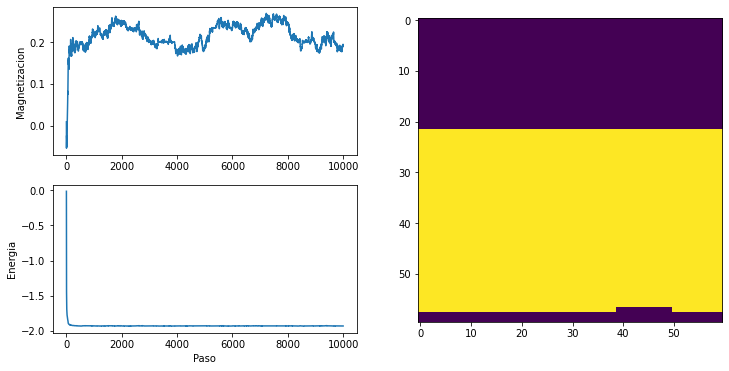

In [ ]:
L = 60 #Lado de la red
beta = 1 / 0.5

nequilibrio = 10000 #Numero de pasos que proponemos para llegar al equilibrio

prob = np.array([np.exp(-4*beta), np.exp(-8*beta)])

#Estado inicial
#Opcion 1: todos los spines apuntan para arriba
#S = np.ones((L, L), dtype=int)
#Opcion 2: matriz aleatoria de 1's y -1's
S = 2*np.random.randint(2, size=(L, L)) - 1

m = np.zeros(nequilibrio) #magnetización en función del paso
e = np.zeros(nequilibrio) #energia por particula en funcion del paso
m[0] = np.mean(S)
e[0] = h(S)

for n in range(1,nequilibrio):
  S, dm, de = metropolis(S, prob)
  m[n] = m[n-1] + dm
  e[n] = e[n-1] + de

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(m)
plt.ylabel('Magnetizacion')
plt.subplot(2, 2, 3)
plt.plot(e)
plt.ylabel('Energia')
plt.xlabel('Paso')
plt.subplot(1, 2, 2)
plt.imshow(S) #plotea el estado final, dandole un color al 1 y otro al -1
plt.show()

# Promedios

Estudiamos cuántos pasos hacen falta para calcular buenos promedios. Para eso, graficamos el valor medio de la magnetización y la energía por partícula en función del número de pasos utilizados para calcularlo (empezando a contar después de haber llegado al equilibrio). Cuando el valor medio se haga constante, el número de pasos será suficiente. De vuelta, el número de pasos apropiado depende de la temperatura y del lado de la red. Van a ver que, cerca de la temperatura crítica, las fluctuaciones se hacen más grandes y por lo tanto es necesario promediar sobre un número más grande de pasos. Para librarnos de las fluctuaciones de la magnetización entre $1$ y $-1$ cerca de la temperatura crítica, que son inmanejables, lo que tomamos es el valor medio de su módulo.

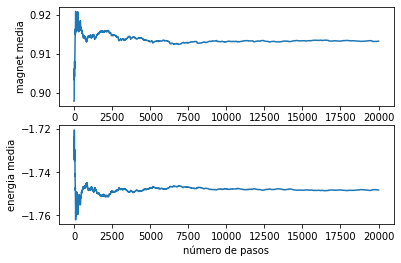

In [ ]:
L=30
beta=1/2

nequilibrio=1000 #Este valor lo decidimos en base a lo anterior
npromedio=20000 #Numero de pasos tentativo para calcular promedios

prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

S=np.ones((L,L),dtype=int) #Estado inicial

for n in range(nequilibrio):
    S,dm,de=metropolis(S,prob) #Termalizamos

m=np.zeros(npromedio)
e=np.zeros(npromedio) #Magnetizacion y energia por particula en funcion del paso
m[0]=np.mean(S)
e[0]=h(S)

mmedia=[m[0]]
emedia=[e[0]] #Valores medios en funcion del numero de pasos para promediar

for n in range(1,npromedio):
  S,dm,de=metropolis(S,prob)
  m[n]=m[n-1]+dm
  e[n]=e[n-1]+de
  mmedia.append(np.mean(abs(m[0:n])))
  emedia.append(np.mean(e[0:n]))

plt.figure()
plt.subplot(2,1,1)
plt.plot(mmedia)
plt.ylabel('magnet media')
plt.subplot(2,1,2)
plt.plot(emedia)
plt.ylabel('energia media')
plt.xlabel('número de pasos')
plt.show()

# Transición de fase

Aquí hay que calcular la magnetización media, la energía media por partícula, la susceptibilidad y el calor específico para varias temperaturas, graficar el resultado y ver que a una temperatura cercana a la crítica se produce un comportamiento casi brusco. Algunos consejos:

*   Para calcular la susceptibilidad y el calor específico no hay que tomar ninguna derivada, hay que usar la relación entre estas cantidades y la varianza de la magnetización y la energía por partícula respectivamente.
*   No propongan un nuevo estado inicial para cada temperatura: aprovechen el último estado de la temperatura anterior, porque así van a necesitar menos pasos para termalizar. Si empiezan a temperaturas bajas, conviene tomar como estado inicial la matriz de $1$'s, y si empiezan a temperaturas altas conviene tomar como estado inicial una matriz aleatoria de $1$'s y $-1$'s.
*   Quizá conviene dar más pasos para termalizar y/o tomar promedios cerca de la temperatura crítica que lejos de ella.





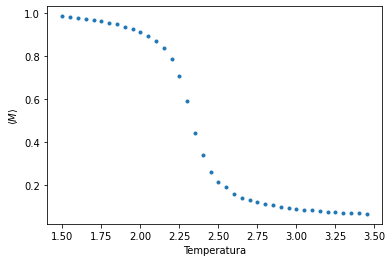

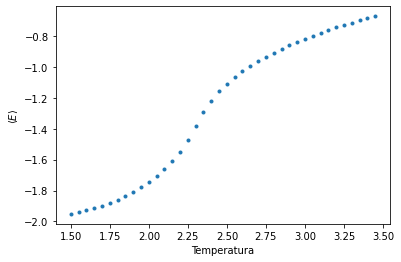

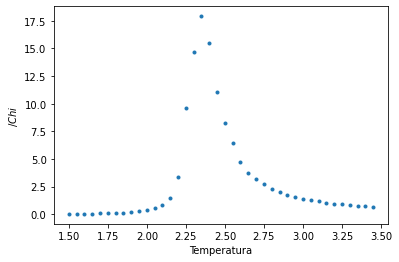

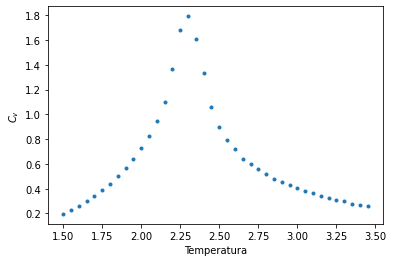

T_c(30) = 2.3500000000000005


In [ ]:


L = 30              # Lado de la red
nequilibrio = 20000   # Numero de pasos para llegar al equilibrio
npromedio = 100000    # Numero de pasos tentativo para calcular promedios

#Estado inicial
S = np.ones((L, L), dtype=int)

# Elegimos un rango de temperaturas y el tamaño del paso
temperaturas = np.arange(1.5, 3.5, 0.05)

# Arrays que contendrán los valores medios para cada temperatura
mmedia = np.zeros(len(temperaturas))
emedia = np.zeros(len(temperaturas))
chimedia = np.zeros(len(temperaturas))
cvmedia = np.zeros(len(temperaturas))

# Magnetizacion y energía en cada paso
m = np.zeros(npromedio) 
e = np.zeros(npromedio) 

for i, temp in enumerate(temperaturas):
    beta = 1/temp
    prob = np.array([np.exp(-4*beta), np.exp(-8*beta)]) 

    # Corremos metropolis para termalizar
    for n in range(1, nequilibrio):
        S, dm, de = metropolis(S, prob)
    
    m[0] = np.mean(S)
    e[0] = h(S)

    # Corremos metropolis para calcular el promedio de las magnitudes deseadas
    for n in range(1, npromedio):
        S,dm,de = metropolis(S,prob)
        m[n] = m[n-1] + dm
        e[n] = e[n-1] + de
    
    # Calculamos los valores medios, la susceptibilidad y el calor específico
    mmedia[i] = np.mean(abs(m))
    emedia[i] = np.mean(e)
    chimedia[i] = L**2*beta*np.std(abs(m))**2
    cvmedia[i] = L**2*beta**2*np.std(e)**2
    

plt.figure()
plt.plot(temperaturas, mmedia, '.')
plt.ylabel(r'$\langle M \rangle$')
plt.xlabel('Temperatura')
plt.figure()
plt.plot(temperaturas, emedia, '.')
plt.ylabel(r'$\langle E \rangle$')
plt.xlabel('Temperatura')
plt.figure()
plt.plot(temperaturas, chimedia, '.')
plt.ylabel(r'$/Chi$')
plt.xlabel('Temperatura')
plt.figure()
plt.plot(temperaturas, cvmedia, '.')
plt.ylabel(r'$C_v$')
plt.xlabel('Temperatura')
plt.show()

print('T_c(%i) =' %L, temperaturas[np.argmax(chimedia)])

Se eligieron las dimensiones de la red y el estado inicial de los espines como todos lso espines apuntando en la misma dirección. Se eligió un rango de temperaturas para realizar el ciclo `for`. Se inicializaron vectores de ceros para ir llenando con los valores de energía y magnetización medias, susceptibilidad y calor especifico. Se inicializan tambien vectores para la energí y la magnetizacion de cada paso del algoritmo de Metrópolis.
Dado que el algoritmo correrá dos veces, la primera para termalizar y la segunda para calcular los promedios, se eligió un numero de pasos para termalizar, en particular se eligió un número que funcione para termalizar en la temperatura crítica que también funciona para las otras temperaturas ya que requieren un menor número de pasos para termalizar, y un número de pasos para realizar el cálculo de los valores medios, de un orden de magnitud mayor. En el principio del ciclo `for` se definen el `beta` y el vector `prob` y luego se corre el algoritmo para termalizar. La magnetización y energía media resultantes de la termalización se toman como el primer valor de los vectores `m` y `e`. Luego se corre el algoritmo, ahora para calcular los valores medios en cada paso, que se guardan en `mmedia` y `emedia` como el promedio de los valres de `m` y `e` hasta ese paso y los valores obtenidos en el último paso se guardan como los valores medios a la temperatura utilizada. A partir de la varianza de la energía y la magnetización se calculan la susceptibilidad y el calor específico respectivamente. El ciclo `for` comienza de nuevo teniendo como estado incial el estado final de la temperatura anterior.

Para calcular el calor específico de la muestra se utilizó que $<E> = \frac{-1}{L^2}\frac{\partial ln Zc}{\partial \beta}$ y $
<E^2> = \frac{1}{L^2}(\frac{\partial^2 ln Zc}{\partial \beta^2} + (\frac{\partial ln Zc}{\partial \beta})^2)$, finalmente $(\Delta E)^2 = <E^2>- <E>^2= \frac{kT^2}{L^2} \frac{\partial <E>}{\partial T} = \frac{kT^2}{L^2} C_v$.

Para obtener la susceptibilidad $\chi$ se realizó un cálculo similar, en el que se utilizó la dependencia del hamiltoniano respecto del campo magnético B y luego se hizo tender el mismo a 0. $<M> = \frac{1}{L^2}\beta^{-1}\frac{\partial ln Zc}{\partial B}$ y $<M^2> = \frac{1}{L^2}\beta^{-2}(\frac{\partial^2 ln Zc}{\partial B^2} + (\frac{\partial ln Zc}{\partial B})^2)$
, finalmente $(\Delta M)^2 = <M^2>- <M>^2= \frac{1}{L^2}\beta^{-2}\frac{\partial^2 ln Zc}{\partial B^2} $. Sabiendo que $\chi = \frac{\partial <M>}{\partial B}$ obtenemos $(\Delta M)^2L\beta=\chi$.



# Correlaciones

La **función de correlación** se define como $g(r)=\langle s_{ij}s_{ij+r}\rangle-\langle s_{ij}\rangle\langle s_{ij+r}\rangle$, y se sabe que tiene la forma $g(r)=ae^{-r/\xi}$. A $\xi$ se lo conoce como la **longitud de correlación**, y es una función de la temperatura que, en el límite termodinámico, diverge a la temperatura crítica. El objetivo de esta sección es ver eso.

Lo primero que hay que hacer es definir dos funciones. La primera, **`cor(S)`**, devuelve un vector $c$ de $L/2$ componentes, donde $L$ es el lado de la red, cuya componente $r$ es el promedio de $s_{ij}s_{ij+r}$ sobre toda la red, es decir, 

$c(r)=\frac{1}{L^2}\sum_{i,j=1}^Ls_{ij}s_{ij+r}.$ 

La segunda función, **`metropolis2(S,prob)`**, implementa el algoritmo de Metropolis, igual que hacía la función **`metropolis(S,prob)`**, pero esta vez, en lugar de devolver el nuevo estado, el incremento de la magnetización y el incremento de energía, devuelve el nuevo estado, el incremento de la magnetización y el incremento del vector $c$. Para definir estas dos funciones deberán prestar mucha atención a las condiciones de contorno periódicas, y tener en cuenta que $c(0)=1$ independientemente del estado, así que el incremento de $c(0)$ siempre es $0$.

In [ ]:
@njit
def cor(S):
    L = len(S)
    c = np.zeros(int(L/2))
    c[0] = 1
    for r in range(1, len(c)):
        for i in range(L):
            for j in range(L):
                c[r] += S[i,j] * S[i,(j+r) % L] / L**2
                
    return c

@njit
def metropolis2(S,prob): 
    L = len(S)
    dm = 0
    dc = np.zeros(int(L/2))

    for k in range(L*L):
        i = np.random.randint(L)
        j = np.random.randint(L)
        spin = S[i,j]
        dif_energia = 2 * S[i,j] * (S[(i+1) % L, j] + S[i-1, j] + S[i, (j+1) % L] + S[i, j-1])
        
        if dif_energia<=0 or np.random.rand()<prob[int((dif_energia-4)/4)]:
            for r in range(1, len(dc)):
                dc[r] += -2 * S[i,j] * (S[i,(j+r) % L] + S[i, j-r]) / L**2
            dm += -2 * S[i,j] / L**2
            S[i, j] *= -1

    return S, dm, dc
 

**Prueba**

In [ ]:
s_prueba = 2*np.random.randint(2, size=(30, 30)) - 1
beta = 1/0.5
prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

c_inicial = cor(s_prueba)
s_prueba, dm, dc = metropolis2(s_prueba, prob)
c_final = cor(s_prueba)

print("Valore inicial:")
print("c = ", c_inicial)
print("")
print("Valor final:")
print("c = ", c_final)
print("")
print("Diferencia obtenida con la función metropolis2(S, prob):")
print("dc = ", dc)
print("")
print("Valor final calvulado con el valor inicial y dc")
print(c_inicial + dc)

Valore inicial:
c =  [ 1.          0.01777778  0.04        0.02222222  0.04888889 -0.01777778
  0.01777778  0.04444444  0.04444444  0.02666667  0.00888889 -0.01333333
  0.00444444  0.04       -0.01777778]

Valor final:
c =  [ 1.          0.37333333  0.09333333 -0.03111111  0.01777778  0.05333333
  0.12        0.03555556 -0.01333333  0.01777778  0.02666667  0.03111111
  0.03111111 -0.00888889 -0.00888889]

Diferencia obtenida con la función metropolis2(S, prob):
dc =  [ 0.          0.35555556  0.05333333 -0.05333333 -0.03111111  0.07111111
  0.10222222 -0.00888889 -0.05777778 -0.00888889  0.01777778  0.04444444
  0.02666667 -0.04888889  0.00888889]

Valor final calvulado con el valor inicial y dc
[ 1.          0.37333333  0.09333333 -0.03111111  0.01777778  0.05333333
  0.12        0.03555556 -0.01333333  0.01777778  0.02666667  0.03111111
  0.03111111 -0.00888889 -0.00888889]


**Explicación cor(S):** 

Empezamos tomando `L = len(S)` como en funciones anteriores e inicializamos el vector `c` con $L/2$ componentes todas iguales a $0$. Asignamos a la primera el valor `c[0] = 1`, ya que este valor es independiente del estado. 

Ahora creamos un búcle `for` que recorra una variable `r` desde $1$ hasta $L/2 - 1$, para definir cada componente. Como cado uno viene definido por una sumatoria sobre dos indices, al igual que cuando definimos `h(S)` anidamos dos búcles `for` que recorran los indices `i` y `j` de $0$ a $L - 1$ y ahora calculamos cada término $S_{ij}S{i j+r}$ y lo sumamos a `c[r]`. De acuerdo a las condiciones de contorno periódicas utilizamos nuvamente el operador módulo para no tener problema con los indices, y expresamos cada término de la sumatoria como `c[r] += S[i,j] * S[i,(j+r) % L] / L**2`.

**Explicación metropolis2(S, prob):**

Esta función escencialmente es la misma que `metropolis(S, prob)` con la diferencia de que dentro del condicional `if dif_energia<=0 or np.random.rand()<prob[int((dif_energia-4)/4)]:`, es decir, cuando se da vuelta un spin debemos calcular la diferencia del vector $c$. 

Para ello primero veamos como varía este vector al cambiar de signo $s_{i j}$. Recordemos que $c(r)$ viene definido por 

$$c(r)=\frac{1}{L^2}\sum_{l,m=1}^L s_{l m}s_{l m+r}.$$ 

Entonces $S_{i j}$ únicamente aparece en dos términos, primero cuando $l = i$ y $m = j$

$$ \frac{s_{l m}s_{l m+r}}{L^2} = \frac{s_{i j}s_{i j+r}}{L^2},$$

pero también cuando $l = i$ y $m = j - r$

$$ \frac{s_{l m}s_{l m+r}}{L^2} = \frac{s_{i j - r}s_{i j}}{L^2}.$$

Entonces al dar vualta el spin $s_{i j}$ únicamente varían estos dos términos

$$ \frac{s_{i j}s_{i j+r} + s_{i j - r}s_{i j}}{L^2} \quad \longrightarrow \quad - \frac{s_{i j}s_{i j+r} + s_{i j - r}s_{i j}}{L^2} $$. 

Y finalmente obtenemos que la variacion de $c(r)$ es 

$$\Delta c(r) = -2 s_{i j} \frac{s_{i j+r} + s_{i j - r}}{L^2}$$.

Entonces creamos un búcle `for` que recorra `r` de $1$ a $L - 1$ para definir las componentes de un vector `dc` previamente inicializado con $0's$. Empezamos a partir del índice $1$ ya que $c(r)$ es el mismo para todo estado y entonces no hay variación en esta componente. 
Para poder calcular esta cantidad utilizamos el operador módulo como venimos haciendo, y entonces a cada componente le sumamos el valor `dc[r] += -2 * S[i,j] * (S[i,(j+r) % L] + S[i, j-r]) / L**2`.

Ahora usamos las funciones que acabamos de definir para calcular la función de correlación a tres temperaturas distintas. Ajustamos los datos obtenidos con una función de la forma $a e^{-r/\xi}$, y de ahí obtenemos la longitud de correlación a esas tres temperaturas.

Longitud de correlacion:
T=2.2 => 1.3420045633735809
T=2.3 => 2.3320645553069337
T=2.5 => 2.0067759832179415


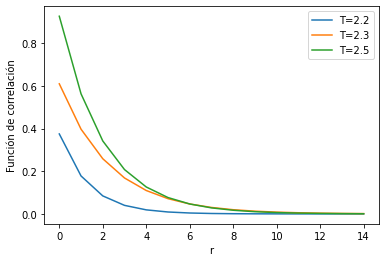

In [ ]:


L=30

nequilibrio=1000 
npromedio=50000


l=int(L/2) #numero de componentes del vector c
m=np.zeros(npromedio) #magnetizacion en funcion del paso
c=np.zeros((l,npromedio)) #vector c en funcion del paso

erres=np.arange(l) #dominio de la funcion de correlacion

def fitcor(r,a,xi): #funcion con la que vamos a ajustar
  return a*np.exp(-r/xi)


S=np.ones((L,L),dtype=int)

print('Longitud de correlacion:')

for T in [2.2,2.3,2.5]:

  beta=1/T

  prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

  #Termalizamos con la funcion metropolis(S,prob), que es mas rapida
  for n in range(nequilibrio):
    S,dm,de=metropolis(S,prob)

  m[0]=np.mean(S)
  c[:,0]=cor(S)

  for n in range(1,npromedio):
    S,dm,dc=metropolis2(S,prob)
    m[n]=m[n-1]+dm
    c[:,n]=c[:,n-1]+dc

  mmedia=np.mean(abs(m))
  correlacion=np.mean(c,axis=1)-mmedia**2 #funcion de correlacion

  #Ajustamos:
  parametros,covarianza=curve_fit(fitcor,erres,correlacion)
  #(la funcion curve_fit devuelve el mejor valor de los parametros
  #y tambien la covarianza, que no vamos a usar)

  print('T={} => {}'.format(T,parametros[1]))
  #plt.plot(erres,correlacion, label='Datos')
  plt.plot(erres,fitcor(erres,parametros[0],parametros[1]),label='T={}'.format(T))
  
plt.xlabel('r')
plt.ylabel('Función de correlación')
plt.legend()
plt.show()

Por último, hay que barrer un rango de temperaturas que incluya la crítica y obtener un gráfico de la longitud de correlación en función de la temperatura.

Longitud de correlacion:
Longitud de correlacion:


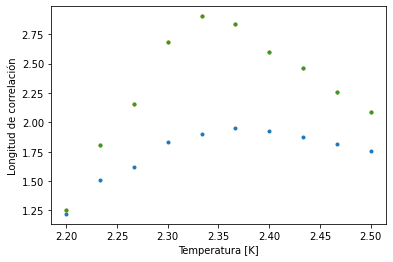

In [ ]:
Lvals=np.array([20,35]) 

nequilibrio=1000 
npromedio=50000

'''
l=int(L/2) #numero de componentes del vector c
m=np.zeros(npromedio) #magnetizacion en funcion del paso
c=np.zeros((l,npromedio)) #vector c en funcion del paso

erres=np.arange(l) #dominio de la funcion de correlacion
'''
def fitcor(r,a,xi): 
  return a*np.exp(-r/xi)



for L in Lvals:
  l=int(L/2) #numero de componentes del vector c
  m=np.zeros(npromedio) #magnetizacion en funcion del paso
  c=np.zeros((l,npromedio)) #vector c en funcion del paso

  erres=np.arange(l) #dominio de la funcion de correlacion
  S=np.ones((L,L),dtype=int)


  Ts=np.linspace(2.2,2.5,10)
  LongCorrs=np.array([])
  for T in Ts:

    beta=1/T

    prob=np.array([np.exp(-4*beta),np.exp(-8*beta)])

    #Termalizamos con la funcion metropolis(S,prob), que es mas rapida
    for n in range(nequilibrio):
      S,dm,de=metropolis(S,prob)

    m[0]=np.mean(S)
    c[:,0]=cor(S)

    for n in range(1,npromedio):
      S,dm,dc=metropolis2(S,prob)
      m[n]=m[n-1]+dm
      c[:,n]=c[:,n-1]+dc

    mmedia=np.mean(abs(m))
    correlacion=np.mean(c,axis=1)-mmedia**2 #funcion de correlacion

    #Ajustamos:
    parametros,covarianza=curve_fit(fitcor,erres,correlacion)
    #(la funcion curve_fit devuelve el mejor valor de los parametros
    #y tambien la covarianza, que no vamos a usar)

    #print('T={} => {}'.format(T,parametros[1]))
    LongCorrs=np.append(LongCorrs,parametros[1])
    
  plt.plot(Ts,LongCorrs,'.',label='L='+str(L))

plt.plot(Ts,LongCorrs,'.')
plt.xlabel('Temperatura [K]')
plt.ylabel('Longitud de correlación')
plt.legend(loc='best')
plt.show()

**Explicación:** usen esta celda para explicar lo que hicieron

Se útlizo el mismo código que en la celda anterior, con el cambio en el barrido de temperaturas, en vez de utilizar `for T in [2.2,2.3,2.5]:` . Se usó

`Ts=np.linspace(2.2,2.5,10)`

`LongCorrs=np.array([])`

`for T in Ts:`

Luego se guardó el valor de $\xi$ dado por el ajuste por $a e^{-r/\xi}$, en el array previamente inicializado `LongCorrs=np.array([])`. 

Cuando el loop termina en el array `LongCorrs`, tengo valores de $\xi$ ordenados respetando el mismo orden que el array `Ts`. Puedo entonces graficar esto mediante `plt.plot(Ts,LongCorrs,'.')`

# Temperatura crítica

La teoría de **finite-size scaling** (Fisher y Barber, Physical Review Letters 28, 1972) muestra que, para una red de Ising bidimensional de lado $L$, el pico de la susceptibilidad ocurre a una temperatura $T_c(L)$ dada por

$$T_c(L)=T_c+\frac{a}{L},$$

donde $T_c$ es la temperatura crítica del sistema en el límite termodinámico y $a$ es una constante. Lo que deben hacer en esta sección es determinar $T_c(L)$ para $L=15,30,60,120$ con una precisión aproximada de $0.01$, graficar en función de $1/L$, ajustar los puntos a una recta y de ahí obtener una estimación para la temperatura crítica.

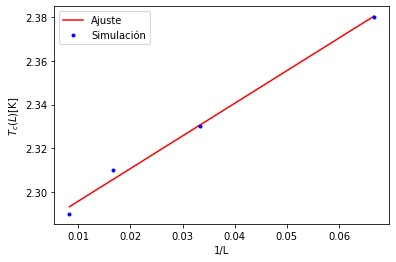

Tc=2.2808695655164106


In [ ]:
def calcularTc(L,nequilibrio,npromedio):
  #Estado inicial
  S = np.ones((L, L), dtype=int)

  # Elegimos un rango de temperaturas y el tamaño del paso
  temperaturas = np.arange(2.25, 2.5, 0.01)

  # Arrays que contendrán los valores medios para cada temperatura
  mmedia = np.zeros(len(temperaturas))
  emedia = np.zeros(len(temperaturas))
  chimedia = np.zeros(len(temperaturas))
  cvmedia = np.zeros(len(temperaturas))

  # Magnetizacion y energía en cada paso
  m = np.zeros(npromedio) 
  e = np.zeros(npromedio) 

  for i, temp in enumerate(temperaturas):
      beta = 1/temp
      prob = np.array([np.exp(-4*beta), np.exp(-8*beta)]) 

      # Corremos metropolis para termalizar
      for n in range(1, nequilibrio):
          S, dm, de = metropolis(S, prob)
      
      m[0] = np.mean(S)
      e[0] = h(S)

      # Corremos metropolis para calcular el promedio de las magnitudes deseadas
      for n in range(1, npromedio):
          S,dm,de = metropolis(S,prob)
          m[n] = m[n-1] + dm
          e[n] = e[n-1] + de

      chimedia[i] = L**2*beta*np.std(abs(m))**2
  
  return temperaturas[np.argmax(chimedia)]


nequilibrio = 20000   # Numero de pasos para llegar al equilibrio
npromedio = 100000    # Numero de pasos tentativo para calcular promedios

TcdeL= lambda x,Tc,cte: Tc+x*cte #Defino la función dada en la consigna, con x=1/L

Lval=np.array([15,30,60,120])


Tc=np.array([])
for i in Lval:
  Ti=calcularTc(i,nequilibrio,npromedio)
  Tc=np.append(Tc,Ti)



parametros,covarianza=curve_fit(TcdeL,1/Lval,Tc) #Ajusto por lineal



plt.plot(1/Lval,TcdeL(1/Lval,parametros[0],parametros[1]),'r-',label='Ajuste')
plt.plot(1/Lval,Tc,'b.',label='Simulación')
plt.legend(loc='best')
plt.ylabel('$T_c (L)$[K]')
plt.xlabel('1/L')
plt.show()

print('Tc={}'.format(parametros[0]))

**Explicación:** usen esta celda para explicar lo que hicieron

El cálculo de Tc funciona consiste en hacer un loop, barriendo los valores pedidos de L, sobre la función `calcularTc(L,nequilibrio,npromedio)` que como su nombre lo indica calcula la temperatura crítica para una dada longitud. Usando el mismo algorítmo que en la sección del cálculo de susceptibilidad, con la diferencia de considerar un paso mucho menor de temperatura, de `0.01`, para cumplir el objetivo planteado.

Luego se grafican estos valores obtenidos de temperatura crítica en función de $1/L$. Ajustando estos puntos por la función:

$$T_c(L)=T_c+\frac{a}{L},$$

Definida en el código como `TcdeL= lambda x,Tc,cte: Tc+x*cte` (con $x=1/L$) puedo obtener el valor de $T_c$, que será la ordenada al origen del ajuste.

# Discusión

Discutan los resultados obtenidos en la práctica, comparando con campo medio y con la solución exacta de Onsager.





Utilizando el algoritmo de metrópolis se obtiene $T_c = 2.256$, este valor es muy cercano al obtenido por Onsager en su solución exacta del modelo de Ising para 2D el cual es $T_{CO} = 2.27$. Por otro lado, esta solución numérica es notoriamente más cercana al valor de Onsager que la temperatura crítica obtenido por medio de la aproximaciónd de campo medio, la cual da 4.

En el caso del cálculo de $\xi$, puede observarse que a mayor $L$, mayor será el pico de $\xi$, lo que se condice con lo esperado por la solución de Onsager, donde para el límite termodinámico de $L\rightarrow \infty $, la longitud de correlación $\xi$ tiende a infinito.

